In [1]:
import numpy as np
import pickle
import keras.backend as K

from keras.layers import  GlobalAveragePooling1D, Input, Activation, MaxPooling1D, BatchNormalization, Dense, Dropout, Conv1D,GlobalMaxPooling1D
from keras.layers import GRU,AveragePooling1D,CuDNNGRU
from keras.layers.merge import Concatenate
from keras.models import Model 
from keras.callbacks import EarlyStopping,ModelCheckpoint


import keras.backend.tensorflow_backend as KTF
import tensorflow as tf
import os


os.environ["CUDA_VISIBLE_DEVICES"] = "1"

config = tf.ConfigProto()
config.gpu_options.allow_growth=True   #不全部占满显存, 按需分配
sess = tf.Session(config=config)

KTF.set_session(sess)

Using TensorFlow backend.
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xhh/anaconda3/envs/py36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xhh/anaconda3/envs/py36/lib/p

In [2]:
import numpy as np
alphabet = np.array(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
                     'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'])

def label_sequence(line, MAX_SEQ_LEN, smi_ch_ind):
	X = np.zeros(MAX_SEQ_LEN)

	for i, ch in enumerate(line[:MAX_SEQ_LEN]):
		X[i] = smi_ch_ind[ch]

	return X #.tolist()

def letter_one_hot(aa):
    one_hot = np.zeros(20)
    for idx, letter in enumerate(alphabet):
        if aa == letter:
            one_hot[idx] = 1
            return one_hot


# Convert an entire protein to one-hot representation.
def protein_one_hot(protein_sequence, MAX_SEQ_LEN):
    #  Remove non-specific AA codes (very few are actually present in this dataset)
    protein_sequence = protein_sequence.replace('B', '')
    protein_sequence = protein_sequence.replace('J', '')
    protein_sequence = protein_sequence.replace('O', '')
    protein_sequence = protein_sequence.replace('U', '')
    protein_sequence = protein_sequence.replace('X', '')
    protein_sequence = protein_sequence.replace('Z', '')
    one_hot_seq = np.zeros( (MAX_SEQ_LEN, 20))
    for idx, aa in enumerate(protein_sequence[:MAX_SEQ_LEN]):
        one_hot_seq[idx, :] = letter_one_hot(aa)
    return one_hot_seq


In [3]:
import keras
feature_len = 768
max_go_len = 512
max_seq_len = 1000

from six.moves import cPickle as pickle #for performance

 
def save_dict(di_, filename_):
    with open(filename_, 'wb') as f:
        pickle.dump(di_, f)

def load_dict(filename_):
    with open(filename_, 'rb') as f:
        ret_di = pickle.load(f)
    return ret_di

protein2go =  load_dict('DM2prot2go.pkl')
protein2seq = load_dict('DM2prot2seq.pkl')
protein2onehot = {}
prot2emb = {}

for key, value in protein2go.items():
    X_go1 =  np.zeros((1,768))
    allgos = value.split(',') 
    allgos = list(set(allgos))
    count = 0
    for  go in  allgos:
        if len(go) > 2:
            feature = np.load('../ncbi_allfeatures4go/'+go+'_0.npy')[1:-1]
        else:
            feature = np.zeros((1,768))
        if count + feature.shape[0] > max_go_len:
            break
        X_go1 = np.concatenate((X_go1,feature ))    
        count += feature.shape[0]   
    prot2emb[key] =  X_go1[1:]  

for key, value in protein2seq.items():
    protein2onehot[key] =  protein_one_hot(value, max_seq_len) 
    

class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self,  ppi_pair_file, batch_size=128):
        'Initialization' 
        self.batch_size = batch_size
        self.ppi_pair_file = ppi_pair_file
         
        self.max_seqlen = max_seq_len
        self.max_golen = max_go_len
        self.protein2go =  load_dict('DM2prot2go.pkl')
        self.protein2seq = load_dict('DM2prot2seq.pkl')
        self.read_ppi()
        self.protein2onehot = protein2onehot
#         self.onehot_seqs()
        self.prot2emb = prot2emb
#         self.prot2embedding() 
         
        self.on_epoch_end()
    
    def read_ppi(self):
        with open(self.ppi_pair_file, 'r') as f:
            self.ppi_pairs  =  f.readlines()
    
     
    
   

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.ppi_pairs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        # Generate data
        X, y = self.__data_generation(indexes)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.ppi_pairs))
         
    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

         
        X_seq1 = np.empty((self.batch_size, self.max_seqlen,20))
        X_seq2 = np.empty((self.batch_size, self.max_seqlen,20))
        y = np.empty((self.batch_size))
        X_go1 = np.empty((self.batch_size, self.max_golen,768))
        X_go2 = np.empty((self.batch_size, self.max_golen,768))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            ppi_pair = self.ppi_pairs[ID]
            p1, p2, label = ppi_pair.rstrip().split('\t')
            if label == '+':
                y[i] = 1
            else:
                y[i] = 0
            X_seq1[i] =  self.protein2onehot[p1]
            X_seq2[i] =  self.protein2onehot[p2]
            
            prot1emb = self.prot2emb[p1]
            X_go1[i,:prot1emb.shape[0]] = prot1emb
            
            prot2emb = self.prot2emb[p2]
            X_go2[i,:prot2emb.shape[0]] = prot2emb
             
            
            
        return [X_go1, X_go2,  X_seq1, X_seq2] ,  y



    def all_data(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization

         
        X_seq1 = np.empty((len(list_IDs_temp), self.max_seqlen,20))

         
        X_seq2 = np.empty((len(list_IDs_temp), self.max_seqlen,20))
        y = np.empty((len(list_IDs_temp)))
        X_go1 = np.empty((len(list_IDs_temp), self.max_golen,768))
        X_go2 = np.empty((len(list_IDs_temp), self.max_golen,768))

        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            ppi_pair = self.ppi_pairs[ID]
            p1, p2, label = ppi_pair.rstrip().split('\t')
            if label == '+':
                y[i] = 1
            else:
                y[i] = 0
            X_seq1[i] =  self.protein2onehot[p1]
            X_seq2[i] =  self.protein2onehot[p2]
            
            prot1emb = self.prot2emb[p1]
            X_go1[i,:prot1emb.shape[0]] = prot1emb
            
            prot2emb = self.prot2emb[p2]
            X_go2[i,:prot2emb.shape[0]] = prot2emb
           
        return [X_go1, X_go2,  X_seq1, X_seq2] ,  y

In [4]:
from keras import backend as K, initializers, regularizers, constraints
from keras.engine.topology import Layer


def dot_product(x, kernel):
    """
    Wrapper for dot product operation, in order to be compatible with both
    Theano and Tensorflow
    Args:
        x (): input
        kernel (): weights
    Returns:
    """
    if K.backend() == 'tensorflow':
        # todo: check that this is correct
        return K.squeeze(K.dot(x, K.expand_dims(kernel)), axis=-1)
    else:
        return K.dot(x, kernel)


class Attention(Layer):
    def __init__(self,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True,
                 return_attention=False,
                 **kwargs):
        """
        Keras Layer that implements an Attention mechanism for temporal data.
        Supports Masking.
        Follows the work of Raffel et al. [https://arxiv.org/abs/1512.08756]
        # Input shape
            3D tensor with shape: `(samples, steps, features)`.
        # Output shape
            2D tensor with shape: `(samples, features)`.
        :param kwargs:
        Just put it on top of an RNN Layer (GRU/LSTM/SimpleRNN) with return_sequences=True.
        The dimensions are inferred based on the output shape of the RNN.
        Note: The layer has been tested with Keras 1.x
        Example:
            # 1
            model.add(LSTM(64, return_sequences=True))
            model.add(Attention())
            # next add a Dense layer (for classification/regression) or whatever...
            # 2 - Get the attention scores
            hidden = LSTM(64, return_sequences=True)(words)
            sentence, word_scores = Attention(return_attention=True)(hidden)
        """
        self.supports_masking = True
        self.return_attention = return_attention
        self.init = initializers.get('glorot_uniform')

        self.W_regularizer = regularizers.get(W_regularizer)
        self.b_regularizer = regularizers.get(b_regularizer)

        self.W_constraint = constraints.get(W_constraint)
        self.b_constraint = constraints.get(b_constraint)

        self.bias = bias
        super(Attention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight((input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        if self.bias:
            self.b = self.add_weight((input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, x, mask=None):
        eij = dot_product(x, self.W)

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        # apply mask after the exp. will be re-normalized next
        if mask is not None:
            # Cast the mask to floatX to avoid float64 upcasting in theano
            a *= K.cast(mask, K.floatx())

        # in some cases especially in the early stages of training the sum may be almost zero
        # and this results in NaN's. A workaround is to add a very small positive number ε to the sum.
        # a /= K.cast(K.sum(a, axis=1, keepdims=True), K.floatx())
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        weighted_input = x * K.expand_dims(a)

        result = K.sum(weighted_input, axis=1)

        if self.return_attention:
            return [result, a]
        return result

    def compute_output_shape(self, input_shape):
        if self.return_attention:
            return [(input_shape[0], input_shape[-1]),
                    (input_shape[0], input_shape[1])]
        else:
            return input_shape[0], input_shape[-1]

In [5]:
from keras.layers import   Embedding
from keras.layers import  GRU, Bidirectional, CuDNNGRU, Lambda, Flatten
from keras.utils import multi_gpu_model
from keras.layers.merge import concatenate

from keras_radam import RAdam
from keras_lookahead import Lookahead


def inception_block(input_tensor, output_size):
    """"""
    con1d_filters = int(output_size/4)
    y = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x1 = Conv1D(con1d_filters, 5, activation="relu", padding='same')(y)

    y = Conv1D(con1d_filters, 1, activation="relu", padding='valid')(input_tensor)
    x2 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(y)

    x3 = Conv1D(con1d_filters, 3, activation="relu", padding='same')(input_tensor)
    x4 = Conv1D(con1d_filters, 1, activation="relu", padding='same')(input_tensor)

    y = Concatenate()([x1, x2, x3, x4])
#     y = MaxPooling1D(4)(mix0)
    # y = AveragePooling1D()(mix0)
#     y = BatchNormalization()(y)

    return y


def build_cnn_gru_model(input_x, con_filters, gru_units):
    x = inception_block(input_x,con_filters )
    x = Dropout(0.3)(x)
    x_gru = Bidirectional(CuDNNGRU(gru_units, return_sequences=True))(input_x)
    x_gru = Dropout(0.3)(x_gru)
     
    x_a = GlobalAveragePooling1D()(x)
    x_b = GlobalMaxPooling1D()(x)
    x_c = Attention()(x)
    x_gru_a = GlobalAveragePooling1D()(x_gru)
    x_gru_b = GlobalMaxPooling1D()(x_gru)
    x_gru_c = Attention()(x_gru)
    x = Concatenate()([x_a, x_b, x_c, x_gru_a, x_gru_b,   x_gru_c])
    x = Dense(256,activation='relu')(x)
    return x



def build_model():
    con_filters = 256
    gru_units = 64
    left_input_go = Input(shape=(max_go_len,feature_len))
    right_input_go = Input(shape=(max_go_len,feature_len))
    
    
    left_input_seq = Input(shape=(max_seq_len,20))
    right_input_seq = Input(shape=(max_seq_len,20))
    
     
 
     
    left_x_go = build_cnn_gru_model(left_input_go, con_filters, gru_units)
    right_x_go = build_cnn_gru_model(right_input_go, con_filters,gru_units)
    
    left_x_seq = build_cnn_gru_model(left_input_seq, con_filters//4, gru_units)
    right_x_seq = build_cnn_gru_model(right_input_seq, con_filters//4, gru_units)
     
    
   
    x =   Concatenate()([left_x_go  , right_x_go, left_x_seq, right_x_seq])
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation='relu')(x)
  
     
    x = Dense(1)(x)
    output = Activation('sigmoid')(x)
    # model = Model([left_input_go, right_input_go], output)
  
    model = Model([left_input_go, right_input_go, left_input_seq, right_input_seq], output)
#     model = multi_gpu_model(model, gpus=2)
    optimizer = Lookahead(RAdam())

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


model = build_model()
model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 768)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000, 20)     0                                            
___________________________________________________________________________

In [10]:
from sklearn.model_selection import StratifiedKFold
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from keras.utils import multi_gpu_model

dataset_name = 'DM2'
for rep in range(3):
    n_splits = 10
    TPRs =  np.zeros(n_splits)
    FPRs = np.zeros(n_splits)
    Precs = np.zeros(n_splits)
    ACCs = np.zeros(n_splits)
    F1s = np.zeros(n_splits)
    MCCs = np.zeros(n_splits)
    AUCs = np.zeros(n_splits)
     
    count = 0
    for split in range(n_splits):
#         train_pairs_file = 'CV/train'+str(rep)+'-'+str(split)
        test_pairs_file = 'CV/test'+str(rep)+'-'+str(split)
#         valid_pairs_file = 'CV/valid'+str(rep)+'-'+str(split)

        batch_size = 48
#         train_generator = DataGenerator(   train_pairs_file,batch_size = batch_size )
        test_generator = DataGenerator(   test_pairs_file,batch_size = batch_size)
#         valid_generator = DataGenerator(   valid_pairs_file,batch_size = batch_size)
         
        # model = build_model_without_att()
        model = build_model()
        save_model_name = 'CV/GoplusSeq'+str(rep)+'-'+str(split) + '.hdf5'
        
        earlyStopping = EarlyStopping(monitor='val_acc', patience=20, verbose=0, mode='max')
        save_checkpoint = ModelCheckpoint(save_model_name, save_best_only=True, monitor='val_acc', mode='max', save_weights_only=True)

         
        # validation_data = (valid_X, valid_Y),  verbose=1,callbacks=[earlyStopping, save_checkpoint]
        #  max_queue_size=16, workers=8, use_multiprocessing=True,
#         hist = model.fit_generator(generator=train_generator,
#                     validation_data=valid_generator,
#                     epochs = 100,verbose=1,callbacks=[earlyStopping, save_checkpoint] )
         
        
        # model = load_model(save_model_name)
        model.load_weights(save_model_name)
        with open(test_pairs_file, 'r') as f:
            test_ppi_pairs  =  f.readlines()

        test_len = len(test_ppi_pairs) 
        list_IDs_temp = np.arange(test_len)

        test_x, y_test = test_generator.all_data(list_IDs_temp)

        y_pred_prob = model.predict(test_x)

       
        y_pred = (y_pred_prob > 0.5)
        auc = metrics.roc_auc_score(y_test, y_pred_prob) 
        f1 = f1_score(y_test, y_pred)
        pre = precision_score(y_test, y_pred)
        acc = accuracy_score(y_test, y_pred)

        precision, recall, _thresholds = metrics.precision_recall_curve(y_test, y_pred_prob)
        pr_auc = metrics.auc(recall, precision)
        mcc = matthews_corrcoef(y_test, y_pred)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        total=tn+fp+fn+tp
        sen = float(tp)/float(tp+fn)
        sps = float(tn)/float((tn+fp))

        tpr = float(tp)/float(tp+fn)
        fpr = float(fp)/float((tn+fp))
        print('--------------------------\n')
        print ('AUC: %f' % auc)
        print ('ACC: %f' % acc) 
        # print("PRAUC: %f" % pr_auc)
        print ('MCC : %f' % mcc)
        # print ('SEN: %f' % sen)
        # print ('SEP: %f' % sps)
        print('TPR:%f'%tpr)
        print('FPR:%f'%fpr)
        print('Pre:%f'%pre)
        print('F1:%f'%f1)
        print('--------------------------\n')
        TPRs[count] = tpr
        FPRs[count] = fpr
        Precs[count] =pre
        ACCs[count] =acc
        F1s[count] =f1
        MCCs[count] =mcc
        AUCs[count] =auc
        count += 1
        del test_x
        del y_test
    print ('mean AUC: %f' % np.mean(AUCs))
    print ('mean ACC: %f' % np.mean(ACCs)) 
    print ('mean MCC : %f' % np.mean(MCCs))
    print('mean TPR:%f'% np.mean(TPRs))
    print('mean FPR:%f'% np.mean(FPRs))
    print('mean Pre:%f'% np.mean(Precs))
    print('mean F1:%f'% np.mean(F1s))
    np.savez('seq_and_go__incep_'+str(rep), AUCs=AUCs, ACCs=ACCs, MCCs=MCCs, TPRs = TPRs, FPRs=FPRs, Precs=Precs, F1s=F1s)

--------------------------

AUC: 0.960857
ACC: 0.893939
MCC : 0.785709
TPR:0.945946
FPR:0.172414
Pre:0.875000
F1:0.909091
--------------------------

--------------------------

AUC: 0.968719
ACC: 0.843750
MCC : 0.725932
TPR:1.000000
FPR:0.303030
Pre:0.756098
F1:0.861111
--------------------------

--------------------------

AUC: 0.818719
ACC: 0.734375
MCC : 0.462682
TPR:0.689655
FPR:0.228571
Pre:0.714286
F1:0.701754
--------------------------

--------------------------

AUC: 0.948242
ACC: 0.750000
MCC : 0.556038
TPR:0.968750
FPR:0.468750
Pre:0.673913
F1:0.794872
--------------------------

--------------------------

AUC: 0.986275
ACC: 0.906250
MCC : 0.824621
TPR:1.000000
FPR:0.200000
Pre:0.850000
F1:0.918919
--------------------------

--------------------------

AUC: 0.956012
ACC: 0.843750
MCC : 0.691443
TPR:0.774194
FPR:0.090909
Pre:0.888889
F1:0.827586
--------------------------

--------------------------

AUC: 0.908824
ACC: 0.843750
MCC : 0.686403
TPR:0.800000
FPR:0.117647
Pre

In [7]:
import numpy as np 
results1 =   np.load( 'seq_and_go__incep_0.npz')
results2 =   np.load( 'seq_and_go__incep_1.npz')
results3 =   np.load( 'seq_and_go__incep_2.npz')
print ('mean AUC: %f' %  ( (np.mean( results1[ 'AUCs' ] )  + np.mean(  results2[ 'AUCs' ] )  + np.mean(results3[ 'AUCs' ]))/3     ) )
print ('mean ACC: %f' %   ( (np.mean( results1[ 'ACCs' ] )  + np.mean(  results2[ 'ACCs' ] )  + np.mean(results3[ 'ACCs' ]))/3) )
print ('mean MCC : %f' %  (  (np.mean( results1[ 'MCCs' ] )  + np.mean(  results2[ 'MCCs' ] )  + np.mean(results3[ 'MCCs' ])     )/3))
print('mean TPR:%f'%    ((np.mean( results1[ 'TPRs' ] )  + np.mean(  results2[ 'TPRs' ] )  + np.mean(results3[ 'TPRs' ])     )/3))
print('mean FPR:%f'%   ( (np.mean( results1[ 'FPRs' ] )  + np.mean(  results2[ 'FPRs' ] )  + np.mean(results3[ 'FPRs' ])     )/3))
print('mean Pre:%f'%    ((np.mean( results1[ 'Precs' ] )  + np.mean(  results2[ 'Precs' ] )  + np.mean(results3[ 'Precs' ])     )/3))
print('mean F1:%f'%    ((np.mean( results1[ 'F1s' ] )  + np.mean(  results2[ 'F1s' ] )  + np.mean(results3[ 'F1s' ])     )/3))

mean AUC: 0.949705
mean ACC: 0.887232
mean MCC : 0.783003
mean TPR:0.905616
mean FPR:0.130484
mean Pre:0.880701
mean F1:0.886034


In [7]:
model.load_weights('CV/GoplusSeq0-0.hdf5')

intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer('dense_7').output)
intermediate_layer_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 512, 768)     0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 512, 768)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 1000, 20)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 1000, 20)     0                                            
____________________________________________________________________________________________

In [9]:
rep = 0
split = 0
test_pairs_file = 'CV/test'+str(rep)+'-'+str(split)
batch_size = 32
         
test_generator = DataGenerator(   test_pairs_file,batch_size = batch_size)

In [10]:
with open(test_pairs_file, 'r') as f:
    test_ppi_pairs  =  f.readlines()

test_len = len(test_ppi_pairs) 
list_IDs_temp = np.arange(test_len)
test_x, y_test = test_generator.all_data(list_IDs_temp)

In [11]:
y_pred = intermediate_layer_model.predict(test_x)

In [12]:
print(y_pred.shape)

(66, 512)


In [13]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0, verbose=1, perplexity=40, n_iter=1000)
X_2d = tsne.fit_transform(y_pred)


[t-SNE] Computing 65 nearest neighbors...
[t-SNE] Indexed 66 samples in 0.000s...
[t-SNE] Computed neighbors for 66 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 66 / 66
[t-SNE] Mean sigma: 4.856797
[t-SNE] KL divergence after 250 iterations with early exaggeration: 48.365337
[t-SNE] KL divergence after 1000 iterations: 0.318576


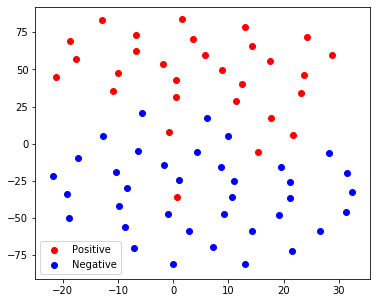

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

colors = 'r',   'b'
plt.figure(figsize=(6, 5))

for i, c, label in zip([0,1], colors, ['Positive', 'Negative']):
    plt.scatter(X_2d[y_test == i, 0], X_2d [ y_test == i, 1], c=c, label=label)
plt.legend()

In [4]:
import numpy as np
aucs = 0
accs = 0
mccs = 0
tprs = 0
fprs = 0
pres = 0
f1s  = 0
for i in range(3):
    for j in range(10):
        results_file = 'CV/sent_fusion_'+str(i)+'-'+str(j)+'.npz'
        results = np.load(results_file)
        aucs += results['AUCs']
        accs += results['ACCs']
        mccs += results['MCCs']
        tprs += results['TPRs']
        fprs += results['FPRs']
        pres += results['Precs']
        f1s += results['F1s']
        
print(aucs/30, accs/30, mccs/30, tprs/30, fprs/30, pres/30, f1s/30)   

0.929564957244453 0.8681186868686869 0.7386845622047421 0.8584363714317109 0.12549765624418144 0.8832711757306612 0.8663409281274809
